In [5]:
from IPython.display import display, Code
from sklearn import metrics as sk_mtr
from src.CategoricalNB import CategoricalNB
import pyro
from src.data import get_factorized_dataset, split_dataset

%matplotlib inline

In [6]:
dataset = get_factorized_dataset()
dataset.head(10)

data = split_dataset(dataset,0.8)

In [7]:
display(Code('src/CategoricalNB.py'))

from pyro import distributions as dist
from torch.distributions import constraints

from .utils import *

pyro.enable_validation(True)


class CategoricalNB:
    def __init__(self, num_epochs=500, lr=1e-2, verbose=False):
        self._num_epochs = num_epochs
        self._lr = lr
        self._verbose = verbose

        self._num_cls = None
        self._cls = None

        self._c_logits = None
        self._cat_probs = None

    def fit(self, X, y):
        pyro.clear_param_store()
        history = train_nb_svi(
            model=self._model,
            guide=self._guide,
            X=X,
            y=y,
            num_epochs=self._num_epochs,
            lr=self._lr,
        )
        if self._verbose:
            visualize_nb_parameters(history)
        else:
            return history

    def predict(self, X):
        pred = pyro.infer.Predictive(
            model=self._model,
            guide=self._guide,
            num_samples=1,
            return_sites=('logP(c|x)',),
        )
        log_pcx = pred(X)['logP(c|x)'].detach().squeeze(0).squeeze(0)
        y_pred = torch.argmax(log_pcx, dim=-1)
        return y_pred

    def _model(self, X, y=None):
        if y is not None:  # training mode
            self._cls = list(set(y))
            self._num_cls = len(self._cls)

            categorical_cols = X.select_dtypes(include=['category']).columns.values

            self._init_c_logits()
            self._init_cat_params(X, categorical_cols)
            self._observe_categorical_features_given_classes(X, y)

        self._observe_classes(X, y)

    def _guide(self, X, y=None):
        pass

    def _init_c_logits(self):
        self._c_logits = pyro.param(
            'c_logits',
            torch.ones(self._num_cls).div(self._num_cls),
            constraint=constraints.simplex
        )

    def _init_cat_params(self, X, categorical_cols):
        self._cat_probs = {
            col: pyro.param(
                f'{col}_prob',
                torch.ones((self._num_cls,  len(set(X[col]))) ).div(len(set(X[col]))),
                constraint=constraints.simplex
            )
            for col in categorical_cols
        }

    def _observe_categorical_features_given_classes(self, X, y):
        for c in self._cls:
            x_c = X[c == y]
            with pyro.plate(f'data-categorical-{c}', x_c.shape[0]):
                for cc, v in self._cat_probs.items():
                    pyro.sample(
                        f'P(x_{cc}|c={c})',
                        dist.Categorical(v[c]),
                        obs=torch.tensor(x_c[cc].values),
                    )

    def _get_log_likelihood(self, X):
        log_lk = []

        for c in range(self._num_cls):
            lps = []

            lps.extend([
                dist.Categorical(v[c]).log_prob(torch.tensor(X[cc].values))
                for cc, v in self._cat_probs.items()
            ])

            log_lk.append(torch.stack(lps).sum(dim=0))

        return torch.stack(log_lk).t()

    def _observe_classes(self, X, y):
        if y is not None:
            y = torch.tensor(y.values)

        log_lk = self._get_log_likelihood(X)

        log_pcx = pyro.deterministic('logP(c|x)', self._c_logits.log() + log_lk)

        with pyro.plate('data-pred', X.shape[0]):
            pyro.sample(
                'c',
                dist.Categorical(logits=log_pcx),
                obs=y,
            )

In [8]:
pyro.clear_param_store()

clf = CategoricalNB(
    num_epochs=30,
    lr=0.05,
    verbose=True,
)

Loss = 204834.94437825686
Loss = 186202.79288899904
Loss = 172281.72721517092
Loss = 157524.47977864748
Loss = 148807.485454917
Loss = 141861.26047933107
Loss = 134938.0102962256
Loss = 131149.29102742678
Loss = 128265.513378501



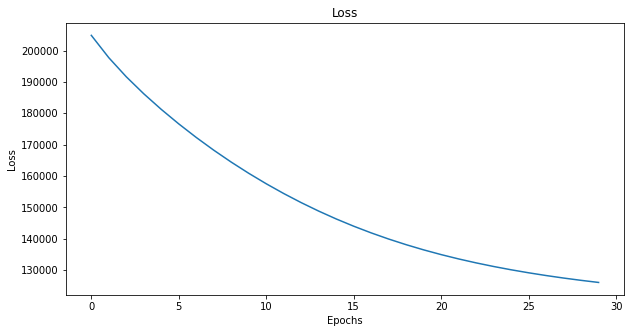

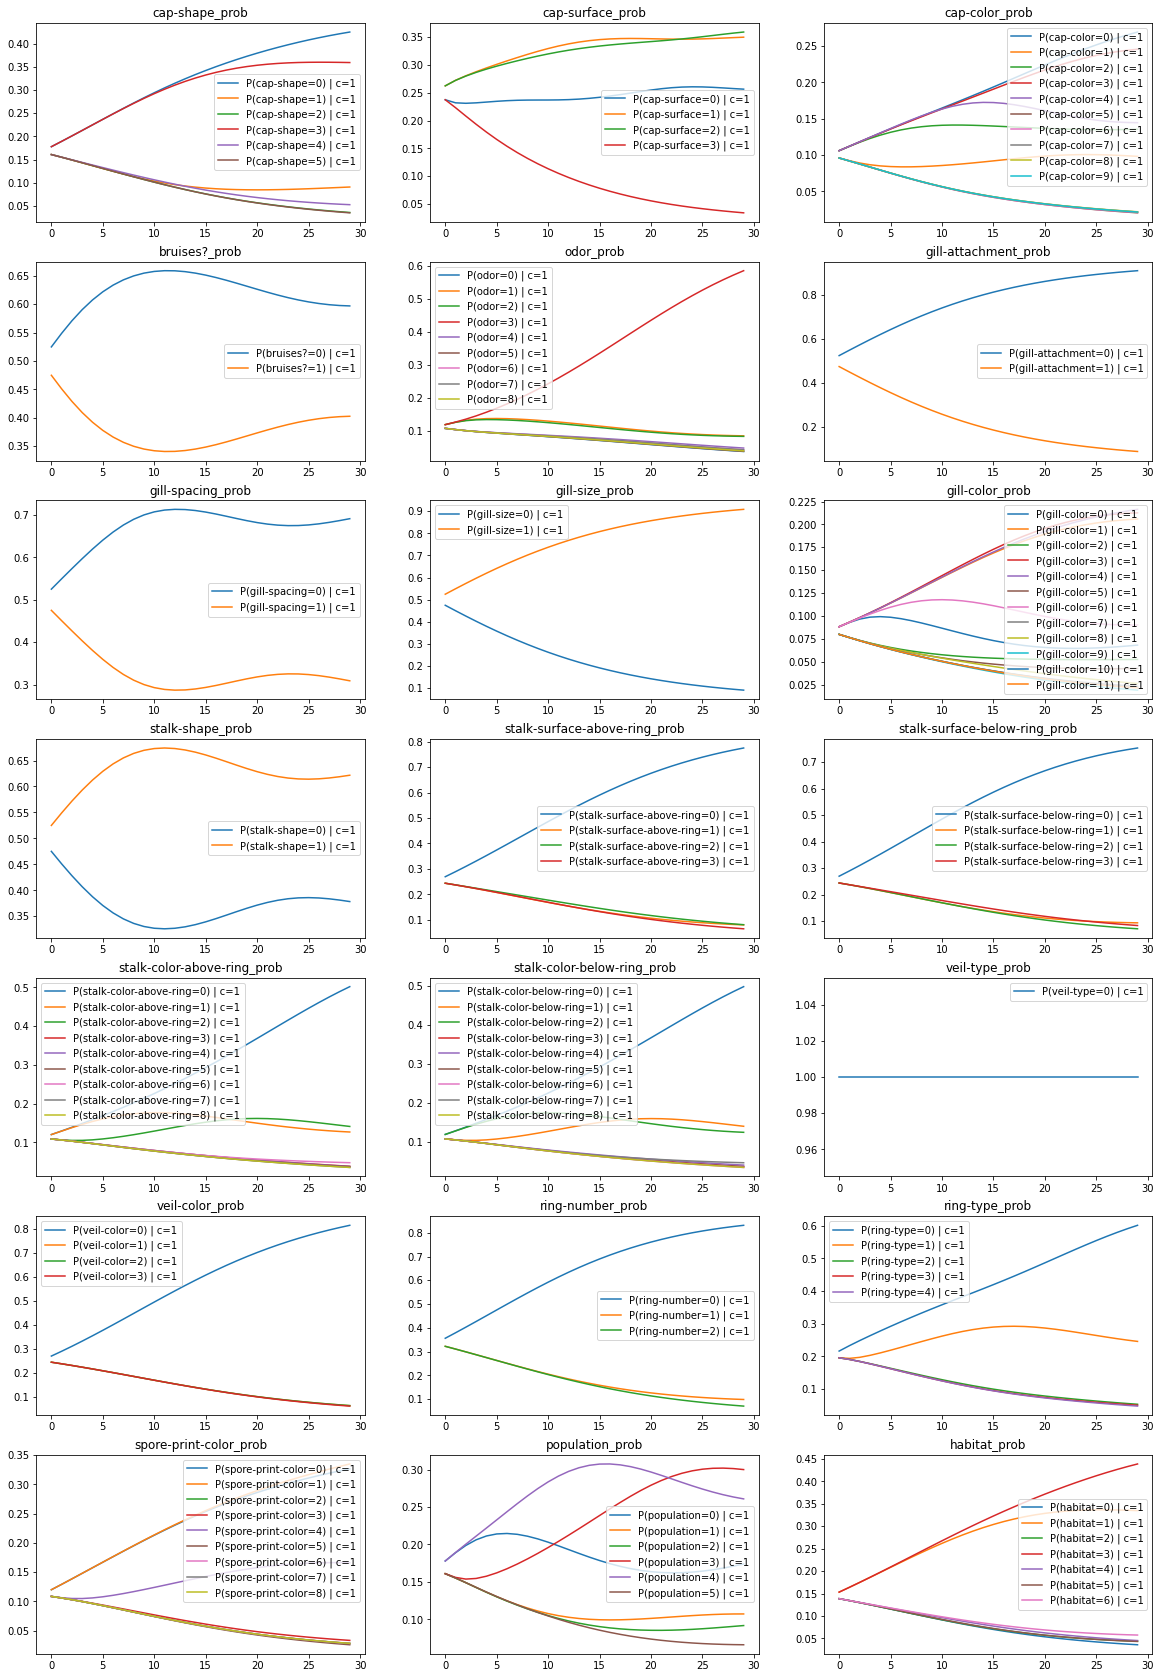

In [9]:
clf.fit(X=data['train']['X'], y=data['train']['y'])

In [10]:
for tt in ('train', 'test'):
    print(tt)
    print(sk_mtr.classification_report(
        y_true=data[tt]['y'],
        y_pred=clf.predict(X=data[tt]['X']),
    ))

train
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      3133
           1       0.93      0.97      0.95      3366

    accuracy                           0.94      6499
   macro avg       0.95      0.94      0.94      6499
weighted avg       0.94      0.94      0.94      6499

test
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       783
           1       0.91      0.97      0.94       842

    accuracy                           0.93      1625
   macro avg       0.94      0.93      0.93      1625
weighted avg       0.93      0.93      0.93      1625

